<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/TG_Previs%C3%A3o_de_carga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from datetime import date

import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
hoje = date.today()
diaSemana = hoje.weekday()
hoje = str(hoje)

In [4]:
baseDIR = "/content/drive/MyDrive/TG/DADOS SUDESTE"
os.listdir(baseDIR)

['SECO_2021-01-27_CARGAHIST.csv',
 'SECO_2021-01-27_TEMPHIST.csv',
 'SECO_2021-01-27_FERIADOS.csv',
 'SECO_2021-01-27_SEPARADOR.csv',
 'SECO_2021-01-27_HORAVERAO.csv',
 'SECO_2021-01-27_PATAMARES.csv',
 'SECO_2021-01-27_HORIZONTE.csv',
 'SECO_2021-01-27_TEMPPREV.csv',
 'SECO_2021-01-27_COMBINA.csv']

In [5]:
historicoCarga = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperatura = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_TEMPHIST.csv'),sep=";",decimal=",")

In [6]:
def basePreprocessing(carga,temperatura):
    dataset = carga.merge(temperatura)
    dataset = dataset.drop(["Min"], axis = 1 )
    dataset = dataset.rename({'Ano': 'Year', 'Mes': 'Month',"Dia":"Day"}, axis=1)
    dataset["Date"] = pd.to_datetime(dataset[["Year","Month","Day"]])
    dataset["Weekday"] = dataset["Date"].dt.dayofweek

    dataset["Carga_Var"] = dataset["Carga"].pct_change()
    dataset["Temp_Var"] = dataset["Temperatura"].pct_change()

    dataset["Carga D-1"] = dataset["Carga"].shift(1, axis = 0)
    dataset = dataset.iloc[1:]

    correlation = dataset["Carga"].corr(dataset["Temperatura"])

    return dataset, correlation

def baseNormalizer(dataset, normalizer, normalize_fit = True):
    
    normalizadorCarga = normalizer
    normalizadorTemp = normalizer

    if normalize_fit:
        dataset[["Carga"]] = normalizadorCarga.fit_transform(dataset[["Carga"]])
        dataset[["Carga D-1"]] = normalizadorCarga.transform(dataset[["Carga D-1"]])
        dataset[["Temperatura"]] = normalizadorTemp.fit_transform(dataset[["Temperatura"]])

    dummies = pd.get_dummies(dataset["Weekday"],prefix="Dia")
    dataset = dataset.join(dummies)
    dataset = dataset.drop(["Date","Weekday"], axis = 1 )
    dataset = dataset.dropna()

    return dataset , normalizadorCarga, normalizadorTemp

In [ ]:
historico, correlation = basePreprocessing(historicoCarga,historicoTemperatura)
historico, normalizadorCarga, normalizadorTemp = baseNormalizer(historico,StandardScaler())
historico = historico.dropna()

cols = [  
    'Year',
    'Month',
    'Day',
    'Hora',
    'Carga',
    'Carga D-1',
    'Temperatura',
    'Carga_Var',
    'Temp_Var',
    'Dia_0',
    'Dia_1',
    'Dia_2',
    'Dia_3',
    'Dia_4',
    'Dia_5',
    'Dia_6']

historico = historico[cols]
base = historico.values
historico.describe().transpose()

In [ ]:
plt.hist2d(historico['Carga'], historico['Temperatura'], bins=(50, 50), vmax=400)

plt.colorbar()
plt.xlabel('Carga [MWm]')
plt.ylabel('Temperatura [°C]')

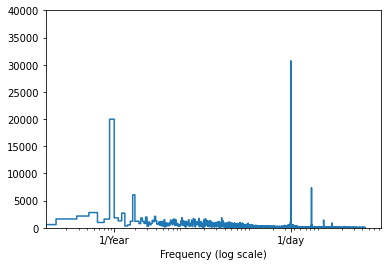

In [29]:
fft = tf.signal.rfft(historico['Temperatura'])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(historico['Temperatura'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))

plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
print(f"A correlação é {round(correlation,4)}")

A correlação é 0.6494


In [ ]:
plt.figure(figsize=(15, 8))
axes = plt.gca()
axes.set_xlim(0,720)

plt.plot(historico["Temperatura"])
plt.plot(historico["Carga"])

In [74]:
Xdataset = historico[['Carga','Carga D-1','Temperatura','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6']]
Ydataset = historico[['Carga']]

n = len(historico)

base_X = Xdataset
base_Y = Ydataset

dias= 30

print(f'Tamanho original da base X = {base_X.shape}, Y = {base_Y.shape}')

x_train = Xdataset[0:int(n*0.7)]
y_train = Ydataset[0:int(n*0.7)]

x_valid = Xdataset[int(n*0.7):int(n*0.9)]
y_valid = Ydataset[int(n*0.7):int(n*0.9)]

x_test = Xdataset[int(n*0.9):]
y_test = Ydataset[int(n*0.9):]

num_features = historico.shape[1]

print(f'    formato dados de treino X = {x_train.shape}, Y = {y_train.shape}')
print(f'    formato dados de validação X = {x_valid.shape}, Y = {y_valid.shape}')
print(f'    formato dados de teste X = {x_test.shape}, Y = {y_test.shape}')

Tamanho original da base X = (61983, 9), Y = (61983, 1)
    formato dados de treino X = (43388, 9), Y = (43388, 1)
    formato dados de validação X = (12396, 9), Y = (12396, 1)
    formato dados de teste X = (6199, 9), Y = (6199, 1)


In [75]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = x_train, val_df=x_valid , test_df=x_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [76]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Carga'])


In [77]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
dir(WindowGenerator)

In [78]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(x_train[:w2.total_window_size]),
                           np.array(x_train[100:100+w2.total_window_size]),
                           np.array(x_train[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
labels shape: (3, 1, 1)


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [79]:
w2.example = example_inputs, example_labels

In [84]:
def plot(self, model=None, plot_col='Carga', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Carga')

WindowGenerator.plot = plot

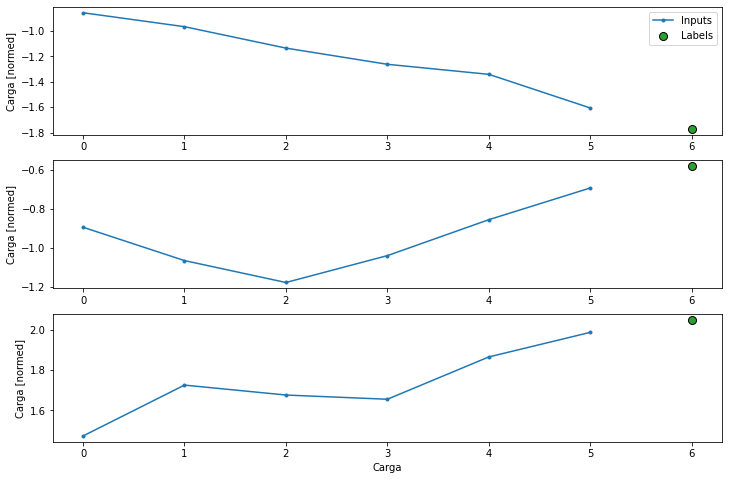

In [85]:
w2.plot()

In [86]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
window_size = 24*diasAnteriores
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
train_set = windowed_dataset(x_train, diasAnteriores,batch_size,shuffle_buffer_size)
print(train_set)

<PrefetchDataset shapes: ((None, None, 8, 1), (None, None, 8, 1)), types: (tf.float64, tf.float64)>


In [ ]:
def createModel():
    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True,input_shape = (previsores.shape[1],9)))
    model.add(Dropout(0.5))

    # model.add(LSTM(units = 50, return_sequences = True))
    # model.add(Dropout(0.3))

    model.add(LSTM(units = 30))
    model.add(Dropout(0.5))

    model.add(Dense(units = 1, activation= "linear"))

    model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mean_absolute_error"])

    return model

In [ ]:
es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath=f"pesos-{hoje}.h5", monitor = "loss", save_best_only = True, verbose=1)

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 59,751
Trainable params: 59,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(previsores, valorReal, epochs = 100, batch_size = 32, callbacks=[es,rlr,mcp])

# Teste e Validação


In [ ]:
model = keras.models.load_model('/content/pesos-2021-02-10.h5') # carrega modelo pré-treinado (OPCIONAL)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 59,751
Trainable params: 59,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
testeDIR = "/content/drive/MyDrive/TG/TESTE" 

In [ ]:
historicoCargaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-02-28_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperaturaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-02-28_TEMPHIST.csv'),sep=";",decimal=",")

In [ ]:
historicoTeste = basePreprocessing(historicoCargaTeste, historicoTemperaturaTeste)

historicoTeste, _ , _ = baseNormalizer(historicoTeste,
                                        StandardScaler(),
                                        normalize_fit=True)

valorRealTeste = historicoTeste.iloc[:, 4].values
valorRealTeste

In [ ]:
historicoTeste[["Carga"]] = normalizadorCarga.fit_transform(historicoTeste[["Carga"]])
historicoTeste[["Temperatura"]] = normalizadorTemp.fit_transform(historicoTeste[["Temperatura"]])
historicoTeste

In [ ]:
entradas = historicoTeste.values
entradas.shape

(62753, 13)

In [ ]:
X_teste = []
Y_teste = []
for i in range(len(entradas) - diasAnteriores,len(entradas)):
    cargaTeste = entradas[(i - diasAnteriores):i,4]
    cargaVerificada = entradas[i,4]
    tempTeste = entradas[(i+1 - diasAnteriores):i+1,5]
    vetorDiaSemana = entradas[(i+1 - diasAnteriores):i+1,6:]
    
    batchTeste = np.column_stack((cargaTeste,tempTeste,vetorDiaSemana))

    X_teste.append(batchTeste)
    Y_teste.append(cargaVerificada)
    
X_teste = np.array(X_teste)
Y_teste = np.array(Y_teste)
print(X_teste.shape)
print(Y_teste.shape)

In [ ]:
previsoes = model.predict(X_teste)

In [ ]:
previsoes = normalizadorCarga.inverse_transform(previsoes)
previsores

In [ ]:
loss = tf.keras.losses.mean_absolute_percentage_error(Y_teste, previsoes[:,0]).numpy()
loss

156.34515

In [ ]:
previsoes

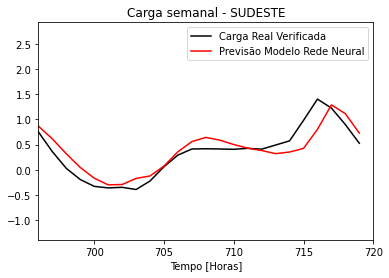

In [ ]:
axes = plt.gca()
axes.set_xlim(696,720)
plt.plot(Y_teste[:], color = "black", label = "Carga Real Verificada")
plt.plot(previsoes[:], color = "red", label = "Previsão Modelo Rede Neural")
plt.title("Carga semanal - SUDESTE")
plt.xlabel("Tempo [Horas]")
plt.ylabel("")
plt.legend()
plt.show()